In [1]:
import tensorflow as tf
import math
from tensorflow import keras 
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import normalize
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import datetime
from datetime import date
import random
import string
import pandas_datareader as pdr
from pandas_datareader import data
from matplotlib.pyplot import figure
plt.style.use('seaborn-muted')

In [2]:
#Sets variables for day stuff
today = date.today()
year = today.year
month = today.month
day = today.day

In [3]:
def getdata(ticker, start = datetime.datetime(year - 1, month, day), end = datetime.datetime(year, month, day)):
    output = pdr.get_data_yahoo(ticker,start, end)
    dates =[]
    for x in range(len(output)):
        newdate = str(output.index[x])
        newdate = newdate[0:10]
        dates.append(newdate)

    output['Date'] = dates
    dateValue = []
    for x in range(len(output)):
        dateValue.append(x)
    output['Date Value'] = dateValue
    return output

In [23]:
#Asks info for what you want predicted
while (True):
    ticker = input("Enter Ticker: ")
    ticker = ticker.upper()
    start = input('Enter Start Year (): ')
    start = int(start)
    #Error Exceptions if you gave a bad ticker/year
    try:
        dataframe = getdata(ticker, start = datetime.datetime(start,1,1))
        dataframe
        break
    except (OverflowError, ValueError):
        print("The year you gave us was prior the ticker's history please try another one")
    except:
        print("The Ticker you gave us doesn't exist please try another one.")

Enter Ticker: spy
Enter Start Year (): 2018


In [24]:
#Setting up the look_back at 15 and using the High values for each day for my data
look_back = 15

data = dataframe["High"]
dataset = data.values
dataset = dataset.astype('float32')
dataset = dataset.reshape(-1, 1)

dates = dataframe['Date']
date = dates.values

In [25]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back = 1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [26]:
# fix random seed for reproducibility
np.random.seed(7)

In [27]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [28]:
#using the first 80% of datapoints for training
split_percent = .8
split = int(split_percent*len(dataset))

In [29]:
#Making the train and test datasets with their corresponding dates
train = dataset[:split]
trainDate = date[:split]
  
test = dataset[split:]
testDate = date[split:]

In [32]:
xtrain, ytrain = create_dataset(train, look_back)
xtest, ytest = create_dataset(test, look_back)
xtrain = np.reshape(xtrain, (xtrain.shape[0], 1, xtrain.shape[1]))
xtest = np.reshape(xtest, (xtest.shape[0], 1, xtest.shape[1]))

In [33]:
model = Sequential()
model.add(LSTM(10, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(xtrain, ytrain, epochs=10, batch_size=1, verbose=2)

Epoch 1/10
783/783 - 1s - loss: 0.0049
Epoch 2/10
783/783 - 0s - loss: 0.0012
Epoch 3/10
783/783 - 0s - loss: 8.6152e-04
Epoch 4/10
783/783 - 0s - loss: 5.7838e-04
Epoch 5/10
783/783 - 0s - loss: 4.7094e-04
Epoch 6/10
783/783 - 0s - loss: 3.7817e-04
Epoch 7/10
783/783 - 0s - loss: 3.7151e-04
Epoch 8/10
783/783 - 0s - loss: 3.5943e-04
Epoch 9/10
783/783 - 0s - loss: 3.4214e-04
Epoch 10/10
783/783 - 1s - loss: 3.0771e-04


In [34]:
trainPredict = model.predict(xtrain)
testPredict = model.predict(xtest)

In [35]:
trainPredict = scaler.inverse_transform(trainPredict)
ytrain = scaler.inverse_transform([ytrain])
testPredict = scaler.inverse_transform(testPredict)
ytest = scaler.inverse_transform([ytest])

In [36]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(ytrain[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(ytest[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 5.67 RMSE
Test Score: 11.33 RMSE


In [37]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

In [38]:
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

In [39]:
#setting up the xaxis labels
datapoints = dataframe.shape[0]
avgYrLen = 275
x = 275
xticks = [0]
years = [start]
yr = start + 1
while datapoints > 0:
    xticks.append(x)
    x = x + avgYrLen
    years.append(yr)
    yr = yr + 1
    datapoints = datapoints - avgYrLen

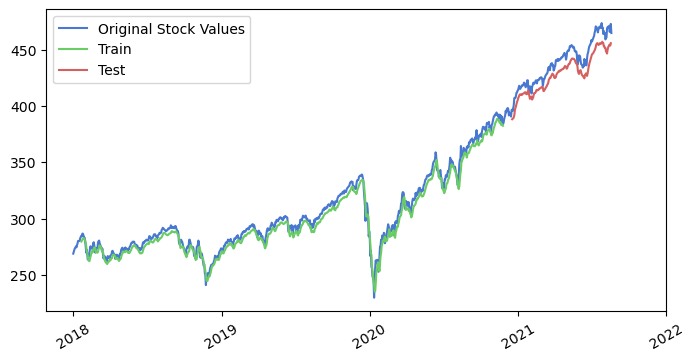

In [40]:
figure(figsize=(8, 4), dpi=100)
plt.plot(scaler.inverse_transform(dataset), label = 'Original Stock Values')
plt.plot(trainPredictPlot, label = 'Train')
plt.plot(testPredictPlot, label = 'Test')
# Set text labels and properties.
plt.xticks(xticks, years,
           rotation=30)  
plt.legend(loc = 'upper left')
plt.show()